**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [0]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo.io
import cv2
import json

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization, Flatten

import warnings
warnings.filterwarnings('ignore')

# MiniProject on Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [0]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [0]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)

        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

The unction act returns an action to perform given a state.The action can be computed from a model the agent learned or a random choice with probability `epsilon`.
The parameter `epsilon` helps the agent to perform exploration hence the agent can explore new paths and gather more information.

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [0]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        # board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board < 0, 2] = 256
        b[self.x,self.y,:]=256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t)) # save frame 

        self.position[self.x, self.y] = 0 # clear previous position

        if action == 0: # move down
            if self.x == self.grid_size-3: # if we are on the bottom border
                self.x = self.x-1 # move up
            else:
                self.x = self.x + 1 # move down
        elif action == 1: # move up
            if self.x == 2: # if we are on the top border
                self.x = self.x+1 # move down
            else:
                self.x = self.x-1 # move up
        elif action == 2: # move to the right
            if self.y == self.grid_size - 3: # if we are on the right border
                self.y = self.y - 1 # move to the left
            else:
                self.y = self.y + 1 # move to the rigth
        elif action == 3: # move to the left
            if self.y == 2: # if we are on the left border
                self.y = self.y + 1 # move to the right
            else:
                self.y = self.y - 1 # move to the left
        else:
            RuntimeError('Error: action not recognized')

        self.position[self.x, self.y] = 1 # set new position
        self.t = self.t + 1
        reward = self.board[self.x, self.y] # get the reward for the action
        self.board[self.x, self.y] = 0 # cleare the cell
        game_over = self.t > self.max_time
        
        # stack the bord and position tables
        state = np.concatenate((
            self.board.reshape(self.grid_size, self.grid_size,1),
            self.position.reshape(self.grid_size, self.grid_size,1)
        ),axis=2)

        # get a 5x5 state centered on the current cell
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:] 

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""
        # random starting position
        self.x = np.random.randint(3, self.grid_size-3)
        self.y = np.random.randint(3, self.grid_size-3)

        # randomly select cells and set positive values
        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        # randomly select cells and set negative values
        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        # create new frames holder
        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))

        malus[bonus>0]=0 # set cells where bonus is > 0 to 0
        self.board = bonus + malus # combine bonus and malus
        self.board[0:2, :] = -1
        self.board[:, 0:2] = -1
        self.board[-2:, :] = -1
        self.board[:, -2:] = -1

        # create position table
        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2, :] = -1
        self.position[:, 0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        
        # set current cell to 0 on board and 1 on position
        self.board[self.x,self.y] = 0
        self.position[self.x, self.y] = 1
        self.t = 0

        # stack the bord and position tables
        state = np.concatenate((
            self.board.reshape(self.grid_size, self.grid_size,1),
            self.position.reshape(self.grid_size, self.grid_size,1)
        ),axis=2)

        # get a 5x5 state centered on the current cell
        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [0]:
# parameters
size = 13
T=200
temperature=0.3
epochs_train=40 # set small when debugging
epochs_test=40 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

The board represents the game environment and position the position of the rat on the grid. Position and board are overlaped to give a full description of the state : the position of the rat on the grid and the visible cells. Since the state is a tensor, we cannot mix a portion of the board and the coordinates x and y of the rate hence we use another tensor to describe the position of the rat.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [0]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        """Random action while avoiding negative cells"""
        # get score for each action
        rewards = [s[3,2,0], s[1,2,0], s[2,3,0], s[2,1,0]]
        # get actions that return positive score
        indexes = [i for i in range(4) if rewards[i] > 0]
        # if no positive action found get cells with 0 score
        if len(indexes) == 0:
            indexes = [i for i in range(4) if rewards[i] == 0]
        
        # if we are surrounded by negative cells
        # this only happens at the first iteration
        if len(indexes) == 0:
            return np.random.randint(self.n_actions)
        
        # we take random decisions
        return np.random.choice(indexes)

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [0]:
def test(agent,env,epochs,prefix=''):
    scores = [] # store all average scores
    # Number of won games
    score = 0
        
    for e in range(epochs):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will end
        game_over = False
        
        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state, train=False)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward
        
        # Save as a mp4
        env.draw(prefix+str(e))

        # Update stats
        score = score + win-lose
        scores.append(score/(1+e))

        print("Win/lose count {}/{}. Average score ({})"
              .format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))
    return scores

In [12]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()

scores = test(agent,env,epochs_test,prefix='random') # test on random agent
HTML(display_videos('random0.mp4'))

Win/lose count 6.0/0. Average score (6.0)
Win/lose count 17.0/0. Average score (11.5)
Win/lose count 9.5/0. Average score (10.833333333333334)
Win/lose count 15.5/0. Average score (12.0)
Win/lose count 17.0/0. Average score (13.0)
Win/lose count 12.5/0. Average score (12.916666666666666)
Win/lose count 15.5/0. Average score (13.285714285714286)
Win/lose count 17.5/0. Average score (13.8125)
Win/lose count 12.5/0. Average score (13.666666666666666)
Win/lose count 11.5/0. Average score (13.45)
Win/lose count 16.5/0. Average score (13.727272727272727)
Win/lose count 11.5/0. Average score (13.541666666666666)
Win/lose count 13.5/0. Average score (13.538461538461538)
Win/lose count 17.5/0. Average score (13.821428571428571)
Win/lose count 15.0/0. Average score (13.9)
Win/lose count 11.5/0. Average score (13.75)
Win/lose count 13.0/0. Average score (13.705882352941176)
Win/lose count 8.5/0. Average score (13.416666666666666)
Win/lose count 15.0/0. Average score (13.5)
Win/lose count 16.5/0. 

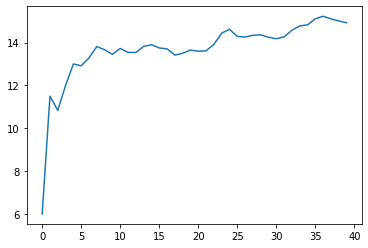

In [13]:
plt.plot(scores)

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




$$
Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t=0}^{+\infty} \gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a]
$$

$$
= r(s,a) + E_{p^{\pi}}[\sum_{t=1}^{+\infty} \gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a]
$$

Computing the second part of the previous expression, we get:
$$
A = E_{p^{\pi}}[\sum_{t=1}^{+\infty} \gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a]
$$

$$
= E_{(s',a')} [\gamma E_{p^{\pi}}[\sum_{t=0}^{+\infty} \gamma^{t}r(s_{t+1},a_{t+1})|s_1=s',a_1=a'] | s_0=s,a_0=a]
$$

$$
= E_{(s',a')} [\gamma Q^\pi(s',a') | s_0=s,a_0=a]
$$

$$
= E_{(s',a')\sim p(.|s,a)} [\gamma Q^\pi(s',a')]
$$

Replacing the result in the first calculus we get the result:
$$
Q^\pi(s,a) = r(s,a) + E_{(s',a')\sim p(.|s,a)} [\gamma Q^\pi(s',a')]
$$

$$
= E_{(s',a')\sim p(.|s,a)} [r(s,a) + \gamma Q^\pi(s',a')]
$$

Now assume we have the best policy $\pi^*$. If we know all the $Q$-function values for the next state $s'$ tha we will reach by taking action $a$ from state $s$, that is to say if we know all $Q^*(s',a')$ where $s' \sim \pi^*(.|s,a)$, then the optimal strategy will be to maximize the expected value of $r(s,a) + \gamma Q^*(s',a')$. Hence we get the formula:
\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')]
\end{equation*}

We need to train our model to get the actions that will return the optimal $Q$-function value. So a possible loss is the distance between the value from the bellman equation of $Q^*$ and the value returned by our model. This can be formulated as:
\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma \max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}
\end{equation*}


***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [0]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory # maximum memory
        self.memory = list() # replay buffer
        self.size = 0 # buffer size

    def remember(self, m):
        # if we are out of memory
        if self.size == self.max_memory:
            self.memory.pop(0) # remove first element in memory
            self.size -= 1 # decrease size
        
        self.memory.append(m) # add new element in memory
        self.size += 1 # increase size

    def random_access(self):
        idx = np.random.randint(self.size) # random element index
        return self.memory[idx]

***
The pipeline we will use for training is given below:

In [0]:
def train(agent,env,epoch,prefix=''):
    scores = []
    losses = []
    

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win, lose, loss, score = [0, 0, 0, 0]

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss += agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose
        scores.append(score)
        losses.append(loss/env.t)

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss/env.t, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    return scores, losses

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [0]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size
        
    def learned_act(self, s):
        # get action from state s
        s_ = np.array([s])
        return np.argmax(self.model.predict(s_))

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size, 5,5,self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            ######## FILL IN
            [s, n_s, a, r, _] = self.memory.random_access()
            input_states[i, :, :, :] = s
            target_q[i] = self.model.predict(np.array([s]))
            
            if game_over_:
                ######## FILL IN
                target_q[i][a] = r
            else:
                ######## FILL IN
                target_q[i][a] = r + self.discount*np.max(self.model.predict(np.array([n_s])))
        ######## FILL IN
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        target_q = np.clip(target_q, -2, 2)

        l = self.model.train_on_batch(input_states, target_q)

        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        # NN Model
        
        ####### FILL IN
        model = Sequential([
          Flatten(input_shape=(5,5,self.n_state)),
          Dense(70, activation='relu'),
          Dense(70, activation='relu'),
          Dense(70, activation='relu'),
          Dense(70, activation='relu'),
          Dense(4, activation='linear')
        ])
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        

In [17]:
mem_size=100
epochs_train=20
lr=0.1
b_size = 20


env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_FC(size, lr=lr, epsilon=0.1, memory_size=mem_size, batch_size=b_size)
scores, losses = train(agent, env, epochs_train, prefix='fc_train')
HTML(display_videos('fc_train0.mp4'))











Epoch 000/020 | Loss 0.0174 | Win/lose count 4.0/11.0 (-7.0)
Epoch 001/020 | Loss 0.0061 | Win/lose count 3.5/5.0 (-1.5)
Epoch 002/020 | Loss 0.0083 | Win/lose count 5.0/6.0 (-1.0)
Epoch 003/020 | Loss 0.0115 | Win/lose count 5.0/4.0 (1.0)
Epoch 004/020 | Loss 0.0071 | Win/lose count 2.0/3.0 (-1.0)
Epoch 005/020 | Loss 0.0145 | Win/lose count 7.5/6.0 (1.5)
Epoch 006/020 | Loss 0.0091 | Win/lose count 3.5/4.0 (-0.5)
Epoch 007/020 | Loss 0.0090 | Win/lose count 2.0/1.0 (1.0)
Epoch 008/020 | Loss 0.0086 | Win/lose count 5.0/3.0 (2.0)
Epoch 009/020 | Loss 0.0108 | Win/lose count 8.5/7.0 (1.5)
Epoch 010/020 | Loss 0.0083 | Win/lose count 4.5/3.0 (1.5)
Epoch 011/020 | Loss 0.0107 | Win/lose count 3.0/5.0 (-2.0)
Epoch 012/020 | Loss 0.0066 | Win/lose count 2.5/6.0 (-3.5)
Epoch 013/020 | Loss 0.0090 | Win/lose count 6.5/4.0 (2.5)
Epoch 014/020 | Loss 0.0076 | Win/lose count 3.5/6.0 (-2.5)
Epoch 015/020 | Loss 0.0075 | Win/lose count 5.5/3.0 (2.5)
Epoch 016/020 | Loss 0.0086 | Win/los

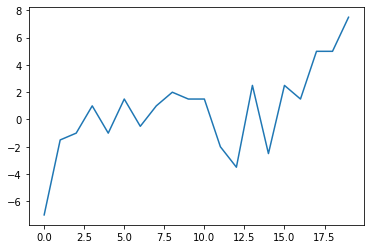

In [18]:
plt.plot(scores)

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [0]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        ###### FILL IN
        model = Sequential([
          Conv2D(6, 2, activation='relu', input_shape=(5,5,self.n_state)),
          Conv2D(6, 2, activation='relu'),
          Flatten(),
          Dense(70, activation='relu'),
          Dense(70, activation='relu'),
          Dense(70, activation='relu'),
          Dense(4, activation='linear')
        ])
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model

In [20]:
env = Environment(grid_size=size, max_time=T, temperature=0.3)
agent = DQN_CNN(size, lr=lr, epsilon=0.1, memory_size=mem_size, batch_size=b_size)
scores, losses = train(agent,env,epochs_train,prefix='cnn_train')
HTML(display_videos('cnn_train10.mp4'))

Epoch 000/020 | Loss 0.0081 | Win/lose count 1.0/6.0 (-5.0)
Epoch 001/020 | Loss 0.0038 | Win/lose count 0.5/4.0 (-3.5)
Epoch 002/020 | Loss 0.0069 | Win/lose count 4.5/3.0 (1.5)
Epoch 003/020 | Loss 0.0055 | Win/lose count 3.5/2.0 (1.5)
Epoch 004/020 | Loss 0.0130 | Win/lose count 6.5/5.0 (1.5)
Epoch 005/020 | Loss 0.0102 | Win/lose count 6.0/2.0 (4.0)
Epoch 006/020 | Loss 0.0131 | Win/lose count 5.0/7.0 (-2.0)
Epoch 007/020 | Loss 0.0136 | Win/lose count 6.5/7.0 (-0.5)
Epoch 008/020 | Loss 0.0062 | Win/lose count 2.5/1.0 (1.5)
Epoch 009/020 | Loss 0.0066 | Win/lose count 6.0/0 (6.0)
Epoch 010/020 | Loss 0.0065 | Win/lose count 5.0/2.0 (3.0)
Epoch 011/020 | Loss 0.0085 | Win/lose count 7.5/6.0 (1.5)
Epoch 012/020 | Loss 0.0059 | Win/lose count 4.0/1.0 (3.0)
Epoch 013/020 | Loss 0.0070 | Win/lose count 2.0/4.0 (-2.0)
Epoch 014/020 | Loss 0.0066 | Win/lose count 4.5/1.0 (3.5)
Epoch 015/020 | Loss 0.0081 | Win/lose count 5.5/8.0 (-2.5)
Epoch 016/020 | Loss 0.0087 | Win/lose count 4.0/6.0

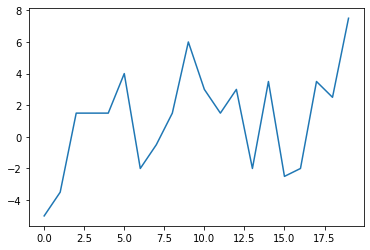

In [21]:
plt.plot(scores)

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [22]:
env = Environment(grid_size=size, max_time=T,temperature=0.5)
agent_cnn = DQN_CNN(size, lr=lr, epsilon = 0.1, memory_size=mem_size, batch_size=b_size)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=lr, epsilon = 0.1, memory_size=mem_size, batch_size=b_size)
agent_cnn.load(name_weights='fc_trainmodel.h5',name_model='fc_trainmodel.json')
print('Test of the CNN')
cnn_test_scores = test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
fc_test_scores = test(agent_fc,env,epochs_test,prefix='fc_test')

Test of the CNN
Win/lose count 0.5/0. Average score (0.5)
Win/lose count 1.0/0. Average score (0.75)
Win/lose count 0.5/0. Average score (0.6666666666666666)
Win/lose count 0.5/0. Average score (0.625)
Win/lose count 0.5/0. Average score (0.6)
Win/lose count 0/0. Average score (0.5)
Win/lose count 1.5/0. Average score (0.6428571428571429)
Win/lose count 0/0. Average score (0.5625)
Win/lose count 5.5/1.0. Average score (1.0)
Win/lose count 0.5/0. Average score (0.95)
Win/lose count 0.5/0. Average score (0.9090909090909091)
Win/lose count 1.5/0. Average score (0.9583333333333334)
Win/lose count 0.5/0. Average score (0.9230769230769231)
Win/lose count 2.0/0. Average score (1.0)
Win/lose count 1.0/0. Average score (1.0)
Win/lose count 1.0/0. Average score (1.0)
Win/lose count 1.0/1.0. Average score (0.9411764705882353)
Win/lose count 0/0. Average score (0.8888888888888888)
Win/lose count 2.5/0. Average score (0.9736842105263158)
Win/lose count 2.5/0. Average score (1.05)
Win/lose count 3.0

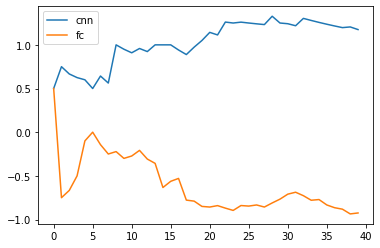

In [23]:
plt.plot(cnn_test_scores, label='cnn')
plt.plot(fc_test_scores, label='fc')
plt.legend()

In [24]:
HTML(display_videos('cnn_test10.mp4'))

In [25]:
HTML(display_videos('fc_test10.mp4'))

The models are not trying to explore the map, the rather loop over cells already visited. When we increase the temperature, we can see the convolutionnal model tries to avoid negative cells while the fully connected one accepts negative cells.

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [0]:
def train_explore(agent,env,epoch,prefix=''):
    pure_eps = 0.99 # epsilon for random strategy
    
    scores = []
    losses = []

    for e in range(epoch):
        agent.set_epsilon(pure_eps/(1+0.5*e)) # usin a decay of \epsilon_0/(1+e)
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win, lose, loss, score = [0, 0, 0, 0]

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action, train=True)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward

            # Apply the reinforcement strategy
            loss += agent.reinforce(prev_state, state,  action, reward, game_over)
        
        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score = win-lose
        scores.append(score)
        losses.append(loss/env.t)

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss/env.t, win, lose, score))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    return scores, losses
        
class EnvironmentExploring(Environment):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        super(EnvironmentExploring, self).__init__(grid_size, max_time, temperature)
        self.malus_position = np.zeros((self.grid_size,self.grid_size))

    def act(self, action, train=False):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position[self.x, self.y] = 0 # remove previous position

        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.position[self.x, self.y] = 1 # set new position
        self.t = self.t + 1
        game_over = self.t > self.max_time

        ## In Environment exploring:
        # You will have to change n_state to 3 because you will use one more layer!
        reward = 0
        if train:
            reward = -self.m_pos[self.x, self.y]
        self.m_pos[self.x, self.y] += 0.2 # mark the cell as visited

        reward = reward + self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        # 3 "feature" states instead of 2
        state = np.concatenate((
            self.board.reshape(self.grid_size, self.grid_size,1),
            self.position.reshape(self.grid_size, self.grid_size,1),
            self.m_pos.reshape(self.grid_size, self.grid_size,1)
        ),axis=2)
        
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3)
        self.y = np.random.randint(3, self.grid_size-3)


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))


        malus[bonus>0]=0

        self.board = bonus + malus
        self.board[0:2, :] = -1
        self.board[:, 0:2] = -1
        self.board[-2:, :] = -1
        self.board[:, -2:] = -1
        self.m_pos = np.zeros((self.grid_size,self.grid_size))

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2, :] = -1
        self.position[:, 0:2] = -1
        self.position[-2:, :] = -1
        self.position[:, -2:] = -1
        self.position[self.x, self.y] = 1

        self.board[self.x,self.y] = 0
        self.m_pos[self.x,self.y] = 0.2
        self.t = 0

        state = np.concatenate((
            self.board.reshape(self.grid_size, self.grid_size,1),
            self.position.reshape(self.grid_size, self.grid_size,1),
            self.m_pos.reshape(self.grid_size, self.grid_size,1)
        ), axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

In [27]:
# Training
epochs_train = 50
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.3)
agent_dqn = DQN_CNN(size, lr=lr, epsilon=0.1, memory_size=mem_size, batch_size=b_size, n_state=3)
train_explore(agent_dqn, env, epochs_train, prefix='cnn_train_explore')
HTML(display_videos('cnn_train_explore10.mp4'))

Epoch 000/050 | Loss 0.0420 | Win/lose count 7.0/88.60000000000005 (-81.60000000000005)
Epoch 001/050 | Loss 0.0174 | Win/lose count 13.5/60.200000000000074 (-46.700000000000074)
Epoch 002/050 | Loss 0.0268 | Win/lose count 14.0/66.00000000000007 (-52.00000000000007)
Epoch 003/050 | Loss 0.0216 | Win/lose count 16.5/47.00000000000004 (-30.500000000000043)
Epoch 004/050 | Loss 0.0299 | Win/lose count 15.5/62.00000000000003 (-46.50000000000003)
Epoch 005/050 | Loss 0.0289 | Win/lose count 18.0/52.999999999999986 (-34.999999999999986)
Epoch 006/050 | Loss 0.0292 | Win/lose count 20.0/38.79999999999998 (-18.799999999999983)
Epoch 007/050 | Loss 0.0166 | Win/lose count 25.5/33.19999999999996 (-7.69999999999996)
Epoch 008/050 | Loss 0.0147 | Win/lose count 19.5/27.999999999999964 (-8.499999999999964)
Epoch 009/050 | Loss 0.0225 | Win/lose count 22.5/35.199999999999974 (-12.699999999999974)
Epoch 010/050 | Loss 0.0212 | Win/lose count 24.0/30.999999999999957 (-6.999999999999957)
Epoch 011/050

In [28]:
# Evaluation
epochs_test=100
scores = test(agent_dqn,env,epochs_test,prefix='cnn_test_explore')
HTML(display_videos('cnn_test_explore30.mp4'))

Win/lose count 24.5/11.0. Average score (13.5)
Win/lose count 18.5/4.0. Average score (14.0)
Win/lose count 19.5/4.0. Average score (14.5)
Win/lose count 23.5/5.0. Average score (15.5)
Win/lose count 21.0/9.0. Average score (14.8)
Win/lose count 25.0/8.0. Average score (15.166666666666666)
Win/lose count 17.0/7.0. Average score (14.428571428571429)
Win/lose count 28.5/15.0. Average score (14.3125)
Win/lose count 22.0/13.0. Average score (13.722222222222221)
Win/lose count 27.0/8.0. Average score (14.25)
Win/lose count 20.5/8.0. Average score (14.090909090909092)
Win/lose count 22.0/8.0. Average score (14.083333333333334)
Win/lose count 28.0/10.0. Average score (14.384615384615385)
Win/lose count 27.0/9.0. Average score (14.642857142857142)
Win/lose count 27.5/7.0. Average score (15.033333333333333)
Win/lose count 26.5/11.0. Average score (15.0625)
Win/lose count 21.0/12.0. Average score (14.705882352941176)
Win/lose count 21.5/5.0. Average score (14.805555555555555)
Win/lose count 28.0

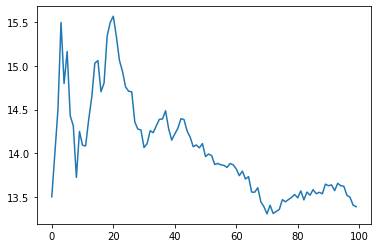

In [29]:
plt.plot(scores)

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

The model that mimicks the behaviour of the previous model has almost the same score. Also the new model behaves as the model from which it learned.

In [0]:
def gen_wining_games(agent, env, n_games=1000):
    """Function for generating winning games."""
    i = 0 # count generated games
    m = env.max_time+1
    n = agent.n_state
    a = agent.n_action

    input_states = np.zeros((n_games, m, 5, 5, n))
    target_a = np.zeros((n_games, m))
    
    while(i < n_games):
        game_over = False
        win, lose = [0, 0] # tracking the score

        state = env.reset() #starting state

        while not game_over:
            input_states[i, env.t, :, :, :] = state # append the state
            # The agent performs an action
            action = agent.act(state)
            target_a[i,env.t] = action

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward
        
        if (win < lose): # remove if game is lost
            input_states[i, :, :, :, :] = 0
            target_a[i, :] = 0
        else:
            i += 1
            if i%100 == 0:
                print("generated: %d"%i)
    return input_states, target_a

In [0]:
class Replay(Agent):
    def __init__(self,lr=0.1, epsilon=0.1, n_state=3):
        super(Replay, self).__init__(epsilon=epsilon)
        self.n_state = n_state
        
        # model of the agent
        model = Sequential([
          Conv2D(6, 2, activation='relu', input_shape=(5,5,n_state)),
          Conv2D(6, 2, activation='relu'),
          Flatten(),
          Dense(70, activation='relu'),
          Dense(70, activation='relu'),
          Dense(70, activation='relu'),
          Dense(4, activation='softmax')
        ])
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "categorical_crossentropy")
        self.model = model

    def learned_act(self, s):
        # get action from state s
        s_ = np.array([s])
        return np.argmax(self.model.predict(s_))

    def reinforce(self, input_states, target_q):
        # Convert labels to categorical one-hot encoding
        one_hot_labels = to_categorical(target_q, num_classes=4)
        #train the model on a winning game
        l = self.model.train_on_batch(input_states, one_hot_labels)

        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

In [0]:
def train_replay(agent, games, prefix=''):
    """Function for training the replay model"""
    states, actions = games
    N = actions.shape[0] # number of games
    losses = []
    loss = 0

    for e in range(N):
        loss += agent.reinforce(states[e], actions[e])

        # Update stats
        if e%100 == 99:
            losses.append(loss/100)

            print("Epoch {:03d}/{:03d} | Loss {:.4f}"
                .format(e+1, N, loss/100))
            loss = 0
            agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
    return losses

In [33]:
games = gen_wining_games(agent_dqn, env, n_games=1000)

generated: 100
generated: 200
generated: 300
generated: 400
generated: 500
generated: 600
generated: 700
generated: 800
generated: 900
generated: 1000


In [34]:
agent = Replay()
losses = train_replay(agent, games, prefix='replay')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 100/1000 | Loss 1.3095
Epoch 200/1000 | Loss 1.1915
Epoch 300/1000 | Loss 1.0320
Epoch 400/1000 | Loss 0.8323
Epoch 500/1000 | Loss 0.7391
Epoch 600/1000 | Loss 0.6443
Epoch 700/1000 | Loss 0.6396
Epoch 800/1000 | Loss 0.6111
Epoch 900/1000 | Loss 0.6005
Epoch 1000/1000 | Loss 0.5735


In [35]:
scores = test(agent,env,epochs_test,prefix='replay')

Win/lose count 20.0/12.0. Average score (8.0)
Win/lose count 21.5/6.0. Average score (11.75)
Win/lose count 22.0/6.0. Average score (13.166666666666666)
Win/lose count 20.0/13.0. Average score (11.625)
Win/lose count 19.0/6.0. Average score (11.9)
Win/lose count 15.5/8.0. Average score (11.166666666666666)
Win/lose count 21.5/6.0. Average score (11.785714285714286)
Win/lose count 23.5/7.0. Average score (12.375)
Win/lose count 16.5/12.0. Average score (11.5)
Win/lose count 19.5/8.0. Average score (11.5)
Win/lose count 24.0/5.0. Average score (12.181818181818182)
Win/lose count 19.5/6.0. Average score (12.291666666666666)
Win/lose count 13.5/9.0. Average score (11.692307692307692)
Win/lose count 19.0/6.0. Average score (11.785714285714286)
Win/lose count 21.0/5.0. Average score (12.066666666666666)
Win/lose count 20.5/7.0. Average score (12.15625)
Win/lose count 23.0/12.0. Average score (12.088235294117647)
Win/lose count 19.0/10.0. Average score (11.916666666666666)
Win/lose count 17.0

In [36]:
HTML(display_videos('replay0.mp4'))

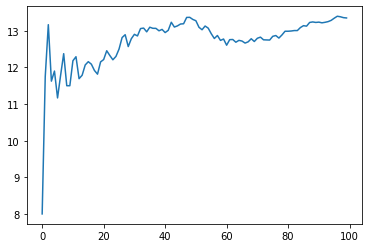

In [37]:
plt.plot(scores)

***